# Binary classification model

#### *Because I am building a model to predict whether a post comes from Tinder or Bumble, I will be using various classification models.*

In [337]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import nltk, re, string, collections
from nltk.util import ngrams
from sklearn.feature_extraction import text 
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

## Read in CSV

In [334]:
dating = pd.read_csv('dating.csv')

In [335]:
dating.head()

,subreddit,selftext,title,combined,text_word_count
0,Bumble,Things that make me swipe left on you without ...,Things that will make me swipe left on you wit...,Things that make me swipe left on you without ...,212
1,Bumble,"If you’ve hit it off with a girl on Bumble, wo...",Men: Do you ever intentionally wait a couple d...,"If you’ve hit it off with a girl on Bumble, wo...",60
2,Bumble,I haven’t gotten a single match since I downlo...,Would love some profile help!,I haven’t gotten a single match since I downlo...,30
3,Bumble,NaN,When to sleep with a dude from bumble?,When to sleep with a dude from bumble?,8
4,Bumble,NaN,No butt stuff? No existence,No butt stuff? No existence,5


In [336]:
# Check balance of two classes. 
dating['subreddit'].value_counts()

Bumble    956
Tinder    928
Name: subreddit, dtype: int64

## Preprocessing: CountVectorizer w/ EDA

In [349]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [350]:
dating['combined'] = [tokenizer.tokenize(text) for text in dating['combined']]

In [351]:
lemmatizer = WordNetLemmatizer()

In [352]:
# Help from Nelli!
# Lemmatize text
dating['lem_text'] = [[lemmatizer.lemmatize(word) for word in text] for text in dating['combined']]
dating.head()

,subreddit,selftext,title,combined,text_word_count,lem_text
0,Bumble,Things that make me swipe left on you without ...,Things that will make me swipe left on you wit...,"[Things, that, make, me, swipe, left, on, you,...",212,"[Things, that, make, me, swipe, left, on, you,..."
1,Bumble,"If you’ve hit it off with a girl on Bumble, wo...",Men: Do you ever intentionally wait a couple d...,"[If, you, ’ve, hit, it, off, with, a, girl, on...",60,"[If, you, ’ve, hit, it, off, with, a, girl, on..."
2,Bumble,I haven’t gotten a single match since I downlo...,Would love some profile help!,"[I, haven, ’t, gotten, a, single, match, since...",30,"[I, haven, ’t, gotten, a, single, match, since..."
3,Bumble,NaN,When to sleep with a dude from bumble?,"[When, to, sleep, with, a, dude, from, bumble, ?]",8,"[When, to, sleep, with, a, dude, from, bumble, ?]"
4,Bumble,NaN,No butt stuff? No existence,"[No, butt, stuff, ?, No, existence]",5,"[No, butt, stuff, ?, No, existence]"


In [353]:
# join lemmatized text together
dating['lem_text'] = [' '.join(words) for words in dating['lem_text']]
dating.head()

,subreddit,selftext,title,combined,text_word_count,lem_text
0,Bumble,Things that make me swipe left on you without ...,Things that will make me swipe left on you wit...,"[Things, that, make, me, swipe, left, on, you,...",212,Things that make me swipe left on you without ...
1,Bumble,"If you’ve hit it off with a girl on Bumble, wo...",Men: Do you ever intentionally wait a couple d...,"[If, you, ’ve, hit, it, off, with, a, girl, on...",60,"If you ’ve hit it off with a girl on Bumble , ..."
2,Bumble,I haven’t gotten a single match since I downlo...,Would love some profile help!,"[I, haven, ’t, gotten, a, single, match, since...",30,I haven ’t gotten a single match since I downl...
3,Bumble,NaN,When to sleep with a dude from bumble?,"[When, to, sleep, with, a, dude, from, bumble, ?]",8,When to sleep with a dude from bumble ?
4,Bumble,NaN,No butt stuff? No existence,"[No, butt, stuff, ?, No, existence]",5,No butt stuff ? No existence


In [354]:
# Convert Bumble and Tinder to binary labels
dating['subreddit'] = dating['subreddit'].map({'Bumble':0, 'Tinder': 1})
dating.head()

,subreddit,selftext,title,combined,text_word_count,lem_text
0,0,Things that make me swipe left on you without ...,Things that will make me swipe left on you wit...,"[Things, that, make, me, swipe, left, on, you,...",212,Things that make me swipe left on you without ...
1,0,"If you’ve hit it off with a girl on Bumble, wo...",Men: Do you ever intentionally wait a couple d...,"[If, you, ’ve, hit, it, off, with, a, girl, on...",60,"If you ’ve hit it off with a girl on Bumble , ..."
2,0,I haven’t gotten a single match since I downlo...,Would love some profile help!,"[I, haven, ’t, gotten, a, single, match, since...",30,I haven ’t gotten a single match since I downl...
3,0,NaN,When to sleep with a dude from bumble?,"[When, to, sleep, with, a, dude, from, bumble, ?]",8,When to sleep with a dude from bumble ?
4,0,NaN,No butt stuff? No existence,"[No, butt, stuff, ?, No, existence]",5,No butt stuff ? No existence


In [192]:
# Define X and y
X = dating['combined']
y = dating['subreddit']

In [193]:
# Instantiate countvectorizer
cvec = CountVectorizer()

In [322]:
type(X)

pandas.core.series.Series

In [195]:
# Fit/transform X
X_t = cvec.fit_transform(X)
X_t = X_t.toarray()

In [196]:
# Turn countvectorized words into dataframe
cvec_df = pd.DataFrame(X_t, columns = cvec.get_feature_names())

In [197]:
cvec_df.head()

,00,000,00pm,02,0x2fwbi,10,100,100th,101,1050,...,yup,yuy,zareklamy,zero,zip,zone,zookeeper,zoom,zoomed,zrjvcc7
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Remove stop words

In [327]:
X1 = dating['combined']
y1 = dating['subreddit']

In [328]:
# Potential list to include in stop words
words_list = ['tinder', 'bumble', 'https', 'reddit', 'www', 'just', 've',
             'feel', 'like', 'com', 'jfe', 'ca', 'mailto', 'flava']

*I updated this list a couple of times based on if I thought the words were too revealing (tinder/bumble), irrelevant (https, reddit, www), or too ubitquitous without relevancy (just).*

In [331]:
# Instantiate countvecorizer with english stop words and words list
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(words_list), ngram_range = (1,2))

In [332]:
X1 = cv.fit_transform(X1)

In [202]:
X1 = X1.toarray()

In [203]:
cv_df = pd.DataFrame(X1, columns = cv.get_feature_names())

In [204]:
cv_df['subreddit'] = y1

In [205]:
cv_df['subreddit'].value_counts()

0    956
1    928
Name: subreddit, dtype: int64

### Find most common words for each subreddit

In [206]:
# From the whole dataframe
common_words1 = cv_df.sum().sort_values(ascending=False).head(20)
common_words1

subreddit    928
don          273
matches      237
people       234
profile      226
time         208
really       188
match        184
know         183
got          178
right        178
app          175
guys         175
date         169
guy          168
dating       161
think        158
want         147
good         141
girl         136
dtype: int64

In [207]:
# Find top 20 most common words for bumble
com_bumble = cv_df.loc[cv_df['subreddit'] == 0].sum().sort_values(ascending=False).head(20)
com_bumble

don        198
people     165
profile    165
matches    165
time       161
date       143
guys       141
really     141
dating     137
guy        132
know       130
match      129
app        128
right      124
got        107
want       106
good        98
girl        97
women       94
think       90
dtype: int64

In [208]:
# Find top 20 most common words for tinder
com_tinder = cv_df.loc[cv_df['subreddit'] == 1].sum().sort_values(ascending=False).head(20)
com_tinder

subreddit    928
don           75
matches       72
got           71
people        69
think         68
account       61
profile       61
bio           56
match         55
new           55
right         54
know          53
said          50
likes         49
app           47
really        47
time          47
banned        46
good          43
dtype: int64

In [209]:
# Why do so many have "subreddit" in them?
dating[dating['combined'].str.contains('subreddit')]

,subreddit,selftext,title,combined,text_word_count
166,0,Which prompts did you answer? Which do you enj...,Favorite Profile Prompts,Which prompts did you answer? Which do you enj...,24
652,0,Hi! I have been on this subreddit quite a bit ...,[18F] My Take on Bumble and Tips to the Men Ou...,Hi! I have been on this subreddit quite a bit ...,684
685,0,I've let quite a few matches I was really inte...,Is it uncool to extend?,I've let quite a few matches I was really inte...,141
739,0,So I'm moving back to the city in a few months...,Do girls actually take Bumble seriously and no...,So I'm moving back to the city in a few months...,130
747,0,I've (38F) not been doing OLD as long as some ...,Date unmatched hours before meet up. Yikes.,I've (38F) not been doing OLD as long as some ...,243
993,1,This happened on Coffee meets Bagel which is a...,Super bummed out and I don’t know what to do...,This happened on Coffee meets Bagel which is a...,133
1295,1,"Hey everyone\n\nI'm new to Tinder, so I'm sorr...",[General Question] Left Swipes,"Hey everyone\n\nI'm new to Tinder, so I'm sorr...",54
1370,1,So I’ve been talking to this girl for the past...,Am I standing my ground or just being a jerk?,So I’ve been talking to this girl for the past...,303
1523,1,Matched with this girl I went to high school w...,How do I make a move?,Matched with this girl I went to high school w...,164
1601,1,NaN,saw this on another subreddit and thought it b...,saw this on another subreddit and thought it ...,0


**Interpretation: From what I can tell, people reference either the subreddit they are in or other subreddits so I don't think I should add subreddit to my list of stop words.**

### Find most common bigrams and trigrams

In [210]:
# vectorize with n-gram range being (2,3) instead of (1,1)
covec = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(words_list), ngram_range = (2,3))

In [211]:
X_covec = covec.fit_transform(dating['combined'])

In [212]:
X_covec = X_covec.toarray()

In [213]:
covec_df = pd.DataFrame(X_covec, columns = covec.get_feature_names())

In [214]:
# add target column
covec_df['subreddit'] = y1
# make sure df is mostly equal
covec_df['subreddit'].value_counts()

0    956
1    928
Name: subreddit, dtype: int64

In [215]:
bigrams = [column for column in covec_df.columns if len(column.split()) == 2]
bigrams[700:703]

['adds facebook', 'adjust filters', 'admirer bug']

In [216]:
trigrams = [column for column in covec_df.columns if len(column.split()) == 3]
trigrams[700:703]

['add shirtless picture', 'add snap got', 'add superlike feature']

In [217]:
# Top bigrams of the whole df 
covec_df[bigrams].sum().sort_values(ascending=False).head(20)

don know           43
swipe right        41
swiped right       39
online dating      36
don want           33
getting matches    27
swipe left         20
poll poll          20
view poll          20
dating apps        19
weeks ago          18
new account        16
couple days        16
dating app         16
days ago           16
swiping right      15
years ago          15
bio said           14
matched girl       14
red flag           14
dtype: int64

In [218]:
# Get df of just bumble subreddits
bumble_covec_df = covec_df.loc[covec_df['subreddit'] == 0]
# Find top 20 bigrams of bumble
bumble_bigrams = bumble_covec_df[bigrams].sum().sort_values(ascending=False).head(20)
# Find top 20 trigrams of bumble
bumble_trigrams = bumble_covec_df[trigrams].sum().sort_values(ascending=False).head(20)

In [219]:
# Get df of just tinder subreddits
tinder_covec_df = covec_df.loc[covec_df['subreddit'] == 1]
# Find top 20 bigrams of tinder
tinder_bigrams = tinder_covec_df[bigrams].sum().sort_values(ascending=False).head(20)
# Find top 20 trigrams of tinder
tinder_trigrams = tinder_covec_df[trigrams].sum().sort_values(ascending=False).head(20)

In [220]:
print(bumble_bigrams)
print(tinder_bigrams)

swiped right       32
online dating      31
swipe right        28
don know           27
don want           25
getting matches    21
swipe left         15
dating app         15
dating apps        15
weeks ago          12
couple days        12
days ago           11
date mode          11
red flag           11
matched guy        11
does mean          11
don really         10
poll poll          10
really want        10
swiping right      10
dtype: int64
don know           16
swipe right        13
bio said           12
view poll          10
new account        10
poll poll          10
got banned         10
phone number        8
don want            8
shadow banned       8
swiped right        7
banned reason       6
need help           6
don think           6
pick line           6
latin america       6
getting matches     6
weeks ago           6
new match           6
new matches         6
dtype: int64


In [221]:
print(bumble_trigrams)
print(tinder_trigrams)

view poll poll                10
new online dating              8
long story short               5
don know happened              4
couple days ago                4
mental health condition        4
online dating scene            4
4ormypeople 2020 11            4
chat existing matches          3
getting matches fine           3
long distance relationship     3
getting lot matches            3
really want know               3
mean swiped right              3
disabled date mode             3
wanted talk phone              3
don really want                3
meet new people                3
met quality guys               3
don know need                  3
dtype: int64
view poll poll             10
removed view poll           5
think think did             4
mexico latin america        3
totally naked looking       3
meet fuck hard              3
guys meet fuck              3
couple days ago             3
average looking guy         3
got new matches             3
naked looking guys         

### Graph the results

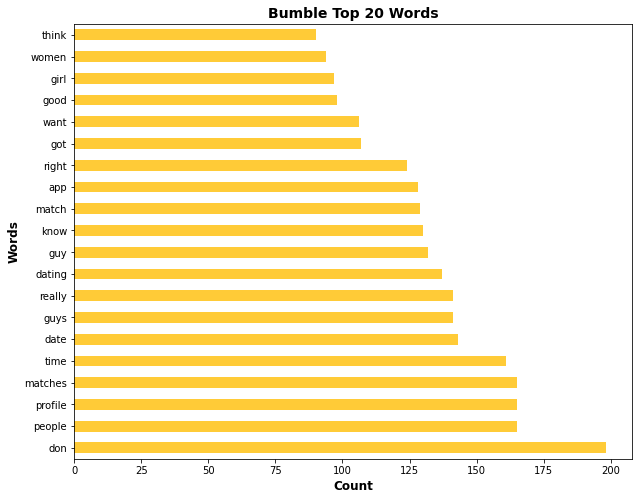

In [278]:
b_plot = com_bumble.plot(kind = 'barh', color = '#FFCB37', figsize = (10,8))
b_plot.set_xlabel('Count', weight='bold', size=12)
b_plot.set_ylabel('Words', weight='bold', size=12)
b_plot.set_title('Bumble Top 20 Words', weight='bold', size=14)
plt.savefig('./images/Bumble_Top_20_Words.png', dpi=300, bbox_inches='tight');

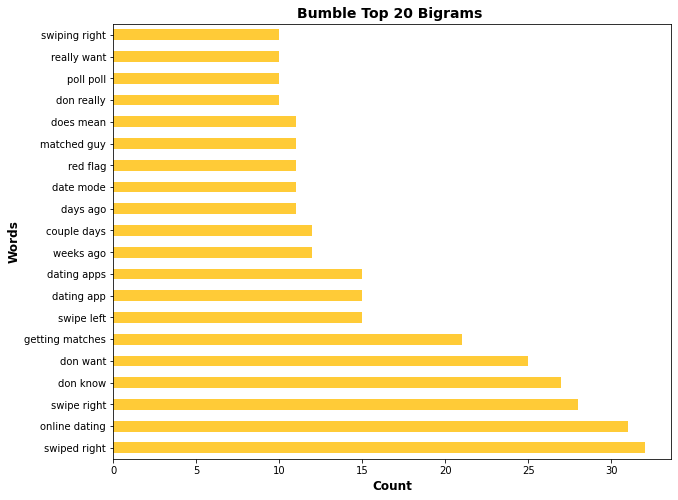

In [279]:
bb_plot = bumble_bigrams.plot(kind = 'barh', color = '#FFCB37', figsize = (10,8))
bb_plot.set_xlabel('Count', weight='bold', size=12)
bb_plot.set_ylabel('Words', weight='bold', size=12)
bb_plot.set_title('Bumble Top 20 Bigrams ', weight='bold', size=14)
plt.savefig('./images/Bumble_Top_20_Bigrams.png', dpi=300, bbox_inches='tight');

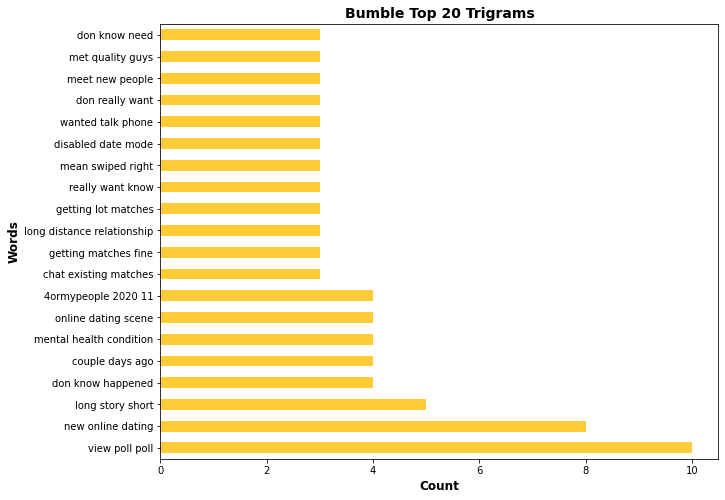

In [280]:
bt_plot = bumble_trigrams.plot(kind = 'barh', color = '#FFCB37', figsize = (10,8))
bt_plot.set_xlabel('Count', weight='bold', size=12)
bt_plot.set_ylabel('Words', weight='bold', size=12)
bt_plot.set_title('Bumble Top 20 Trigrams', weight='bold', size=14)
plt.savefig('./images/Bumble_Top_20_Trigrams.png', dpi=300, bbox_inches='tight');

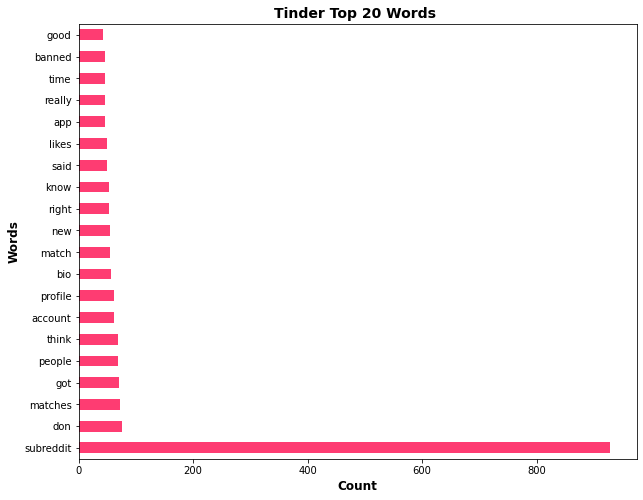

In [281]:
t_plot = com_tinder.plot(kind = 'barh', color = '#FE3C72', figsize = (10,8))
t_plot.set_xlabel('Count', weight='bold', size=12)
t_plot.set_ylabel('Words', weight='bold', size=12)
t_plot.set_title('Tinder Top 20 Words ', weight='bold', size=14)
plt.savefig('./images/Tinder_Top_20_Words.png', dpi=300, bbox_inches='tight');

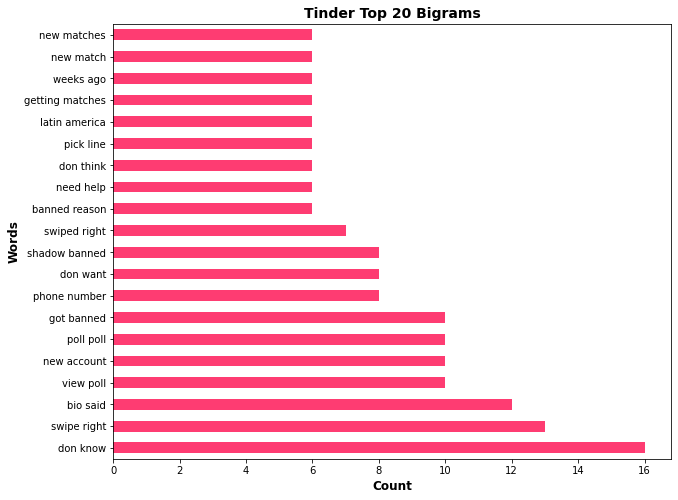

In [282]:
tb_plot = tinder_bigrams.plot(kind = 'barh', color = '#FE3C72', figsize = (10,8))
tb_plot.set_xlabel('Count', weight='bold', size=12)
tb_plot.set_ylabel('Words', weight='bold', size=12)
tb_plot.set_title('Tinder Top 20 Bigrams', weight='bold', size=14)
plt.savefig('./images/Tinder_Top_20_Bigrams.png', dpi=300, bbox_inches='tight');

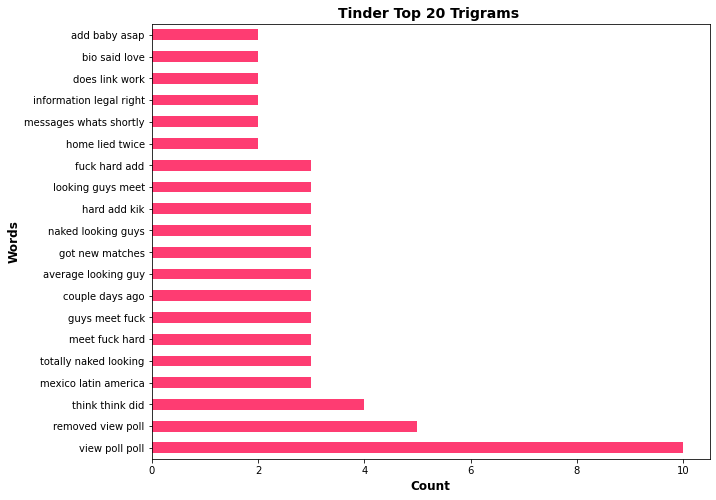

In [305]:
tt_plot = tinder_trigrams.plot(kind = 'barh', color = '#FE3C72', figsize = (10,8))
tt_plot.set_xlabel('Count', weight='bold', size=12)
tt_plot.set_ylabel('Words', weight='bold', size=12)
tt_plot.set_title('Tinder Top 20 Trigrams ', weight='bold', size=14)
plt.savefig('./images/Tinder_Top_20_Trigrams.png', dpi=300, bbox_inches='tight');

## Baseline Accuracy

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state= 42)

In [230]:
y_test.value_counts(normalize=True)

0    0.507067
1    0.492933
Name: subreddit, dtype: float64

**Interpretation: Right now the baseline accuracy is about 50/50. My goal is to make a model that is a better predictor than 50/50.**

## Modeling

*For each of these models I used my words_list as stop words as I thought they would interfere with predictions.*

### Create a transformer

In [90]:
# ref lab 5.02
# adapted from https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

*After testing the dense transformer with my models I didn't get different scores/best paramaters.*

### Pipeline/Gridsearch: CountVectorizer and Multinomial Naive Bayes

In [45]:
type(X_train)

pandas.core.series.Series

In [48]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = words_list)),
    ('_', DenseTransformer()),
    ('nb', MultinomialNB())
])

In [49]:
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [None, 'english']
}

In [50]:
# Instantiate GridSearchCV

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)

In [51]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['tinder',
                                                                    'bumble',
                                                                    'https',
                                                                    'reddit',
                                                                    'www',
                                                                    'just',
                                                                    've',
                                                                    'feel',
                                                                    'like',
                                                                    'com',
                                                                    'jfe'])),
                                       ('_',
                                        <__main

In [52]:
# What's the best score?
print(gs.best_score_)

0.6388351192533702


In [53]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [54]:
# Score model on training set.
gs.score(X_train, y_train)

0.8125948406676783

In [55]:
# Score model on testing set.
gs.score(X_test, y_test)

0.6625441696113075

**Interpretation: While this model is overfit, the best score and test score are pretty similar and beat our baseline of 50%.**

### Pipeline/Gridsearch: Tfidf and Multinomial Naive Bayes

In [59]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = words_list)),
    ('_', DenseTransformer()),
    ('nb', MultinomialNB())
])

In [60]:
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]
}

In [61]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, param_grid = pipe_tvec_params, cv=5)

In [62]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['tinder',
                                                                    'bumble',
                                                                    'https',
                                                                    'reddit',
                                                                    'www',
                                                                    'just',
                                                                    've',
                                                                    'feel',
                                                                    'like',
                                                                    'com',
                                                                    'jfe'])),
                                       ('_',
                                        <__main

In [63]:
print(gs_tvec.best_score_)

0.6327629911280102


In [64]:
gs_tvec.best_params_

{'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [65]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.830804248861912

In [66]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.6554770318021201

**Interpretation: Similar to the model above, this model is overfit, but the best score and test score are pretty similar and beat our baseline of 50%. The one above is slightly better though.**

### Pipeline/Gridsearch: Tfidf and KNN

In [71]:
pipe_tk = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = words_list)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [72]:
pipe_tk_params = {'knn__p': [1,2],
                 'knn__weights': ['uniform', 'distance'],
                 'knn__n_neighbors': [3,5,10],
                 'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
                  'tvec__stop_words': [None, 'english'],
                  'tvec__ngram_range': [(1,1), (1,2)]}

In [73]:
gs_tk = GridSearchCV(pipe_tk, param_grid = pipe_tk_params, cv=5)

In [74]:
gs_tk.fit(X_train, y_train);

In [75]:
gs_tk.best_score_

0.601621730614126

In [76]:
gs_tk.best_params_

{'knn__n_neighbors': 10,
 'knn__p': 2,
 'knn__weights': 'uniform',
 'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [77]:
gs_tk.score(X_test, y_test)

0.49823321554770317

In [78]:
gs_tk.score(X_train, y_train)

0.4969650986342944

**Interpretation: While this model is not overfit, it does not perform any better than our baseline so I won't use it.**

### Pipeline/Gridsearch: Countvectorizer and SVC

In [301]:
pipe_svc = Pipeline([
    ('cvec', CountVectorizer(stop_words = words_list)),
    ('svc', SVC())
])

p_grid = {
    
    'svc__C':np.linspace(0, 5, 20),
    'svc__degree':[2],
    'cvec__max_features': [3_000],
    'cvec__min_df': [2],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,1)],
    'cvec__stop_words': ['english']
}

gs_svc = GridSearchCV(pipe_svc, param_grid=p_grid, cv=5, n_jobs = 4)

gs_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['tinder',
                                                                    'bumble',
                                                                    'https',
                                                                    'reddit',
                                                                    'www',
                                                                    'just',
                                                                    've',
                                                                    'feel',
                                                                    'like',
                                                                    'com',
                                                                    'jfe', 'ca',
                                                                    'mailto',
           

In [302]:
gs_svc.best_score_

0.7025895840534624

In [303]:
gs_svc.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'svm__C': 2.1052631578947367,
 'svm__degree': 2}

In [304]:
print(gs_svc.score(X_train, y_train))
print(gs_svc.score(X_test, y_test))

0.849772382397572
0.7190812720848057


## BEST MODEL Pipeline/Gridsearch: CountVectorizer and RandomForest

In [296]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words = words_list)),
    ('rf', RandomForestClassifier(random_state=33))
])

params = {'rf__n_estimators' : [75, 80],
          'rf__max_features' : [None, 'auto'],
          'rf__max_depth' : [5, 6],
          'cvec__max_features': [3_000],
          'cvec__min_df': [2],
          'cvec__max_df': [.9],
          'cvec__ngram_range': [(1,1)],
          'cvec__stop_words': ['english']
}

gs_rf = GridSearchCV(pipe_rf, param_grid = params, cv = 5)

gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['tinder',
                                                                    'bumble',
                                                                    'https',
                                                                    'reddit',
                                                                    'www',
                                                                    'just',
                                                                    've',
                                                                    'feel',
                                                                    'like',
                                                                    'com',
                                                                    'jfe', 'ca',
                                                                    'mailto',
           

In [104]:
gs_rf.best_score_

0.7033413987786611

In [106]:
gs_rf.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'rf__max_depth': 5,
 'rf__max_features': 'auto',
 'rf__n_estimators': 75}

In [121]:
print(gs_rf.score(X_train, y_train))
print(gs_rf.score(X_test, y_test))

0.7382397572078907
0.7296819787985865


**Interpretation: This model has the second highest accuracy score (73.0% vs. 73.1%). However, the logistic regression model that scored slightly better is very very overfit while this one scores very well when comparing test/train scores. This is the model I will use.**

#### Save the best model for further evaluation below

In [122]:
# Save the best model
rf_model = gs_rf.best_estimator_

### Pipeline/Gridsearch: Tfdif and RandomForest

In [115]:
pipe_rft = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = words_list)),
    ('rft', RandomForestClassifier(random_state=33))
])

params = {'rft__n_estimators' : [80, 85],
          'rft__max_features' : [None, 'auto'],
          'rft__max_depth' : [6, 7],
          'tvec__max_features': [2_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1)]
}

gs_rft = GridSearchCV(pipe_rft, param_grid = params, cv = 5)

gs_rft.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['tinder',
                                                                    'bumble',
                                                                    'https',
                                                                    'reddit',
                                                                    'www',
                                                                    'just',
                                                                    've',
                                                                    'feel',
                                                                    'like',
                                                                    'com',
                                                                    'jfe'])),
                                       ('rft',
                                        Rando

In [116]:
gs_rft.best_score_

0.720797326880977

In [117]:
gs_rft.best_params_

{'rft__max_depth': 7,
 'rft__max_features': None,
 'rft__n_estimators': 80,
 'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [118]:
gs_rft.score(X_train, y_train)

0.7905918057663126

In [119]:
gs_rft.score(X_test, y_test)

0.7279151943462897

### Pipeline/Gridsearch: CountVectorizer and Logistic Regression

In [79]:
pipe_log = Pipeline([
    ('cvec', CountVectorizer(stop_words = words_list)),
    ('_', DenseTransformer()),
    ('log', LogisticRegression(solver = 'liblinear'))
])

pipe_log_params = {'cvec__max_features': [2_000, 3_000, 4_000],
                   'cvec__min_df': [2, 3],
                   'cvec__max_df': [.9, .95],
                   'cvec__ngram_range': [(1,1), (1,2), (1,3)],
                   'cvec__stop_words': [None, 'english']}

gs_log = GridSearchCV(pipe_log, param_grid = pipe_log_params, cv=5)

gs_log.fit(X_train, y_train);

In [80]:
gs_log.best_score_

0.7154712524484387

In [318]:
gs_log.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': 'english'}

In [319]:
gs_log.score(X_train, y_train)

0.9226100151745068

In [320]:
gs_log.score(X_test, y_test)

0.7314487632508834

**Interpretation: This model has the highest accuracy test score but just slightly and it is very overfit. Therefore I'm not going to choose it.**

### Model using "text_word_count" in model as well

*I thought it was interesting that tinder had about 4x as long of posts as bumble. Therefore, I wanted to test whether including it improves my most accurate model.*

In [296]:
# bring in countvectorized dataframe from above
cv_df.head()

,00,000,00pm,02,0x2fwbi,10,100,100th,101,1050,...,yuy,zareklamy,zero,zip,zone,zookeeper,zoom,zoomed,zrjvcc7,text_word_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,197
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,43
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [219]:
# Add the text word count column from the original dating df
cv_df['text_word_count'] = dating['text_word_count']

In [297]:
# Define a new X and y
X2 = cv_df.drop('subreddit', axis=1)
y2 = cv_df['subreddit']

In [291]:
# Played around a bit with test size and 20% seemed best
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, stratify = y, random_state= 42)

In [292]:
# I needed to increase max iterations for the model to run
log = LogisticRegression(max_iter = 1000)

In [293]:
log.fit(X_train2, y_train2);

In [294]:
log.score(X_train2, y_train2)

0.9256801592568016

In [295]:
log.score(X_test2, y_test2)

0.6737400530503979

**Interpretation: This model is very overfit and does not perform better than my previous and best performing model.**

## Confusion Matrix and further Evaluation

In [123]:
preds = rf_model.predict(X_test)

In [125]:
tn, fp, fn, tp = confusion_matrix(y_test,
                                  preds).ravel()
print(confusion_matrix(y_test,
                       preds))

[[170 117]
 [ 36 243]]


In [126]:
# Calculate sensitivity (true pos. rate)
sens = tp / (tp + fn)
print(round(sens, 3))

0.871


In [128]:
# Calculate specificity (true neg. rate)
spec = tn / (tn + fp)
print(round(spec,3))

0.592


In [129]:
print(f' False positives: {fp}')
print(f' False negatives: {fn}')

 False positives: 117
 False negatives: 36


**Interpretation:<br>
Among the posts predicted as being classified as Tinder, 87.1% were accurate.<br>
Among the posts predicted as being classified as Bumble, 59.2% were accurate.<br>
This would lead me to believe that there is text from Tinder that is quite unique, whereas Bumble has a lot of overlapping text with Tinder and not much that is unique.**

## Conclusions

Our model was able to predict with 73% accuracy whether a post was from Bumble or Tinder. This beats our baseline of 50% significantly enough to show a distinction between the two.

**Recommendation:** I would recommend that single people interested in a serious relationship sign up for Bumble over Tinder because the common words, trigrams, and bigrams used in Tinder along with the shorter length of posts indicate a lower level of seriousness. 